In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [3]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    X = df[[x for x in df.columns if x != 'price']]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join([x for x in df.columns if not x =='price'])+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [4]:
rome = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfm.csv',
                         
                   encoding='utf8')

In [6]:
X, y = pred_target(rome)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
X_train.shape, X_test.shape

((10926, 25), (4683, 25))

In [10]:
linmod = LinearRegression()

In [11]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.48628298  0.45662238  0.49340615  0.47073849  0.48254229  0.49603355
  0.5275763   0.49100008  0.49378123  0.53122337]
0.492920682307
0.0215495910766


In [12]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.505065979529


In [13]:
residuals = y_test - predictions
residuals

array([-0.15324152,  0.04328878,  0.09675251, ...,  0.42713235,
        0.25133071,  0.47636787])

In [14]:
np.mean(predictions)


4.5730086695425349

In [15]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
linmod.score(X_test, y_test)

0.50853018133347805

In [17]:
#linmod.coef_

In [18]:
print np.mean(y_train), np.mean(y_test)

4.55977603136 4.57319490347


In [19]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
enet_cv.fit(Xn_train, y_train)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [23]:
print enet_cv.l1_ratio_
print enet_cv.alpha_

0.31306122449
0.00562767142942


In [24]:
enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)


ElasticNet(alpha=0.005627671429415745, copy_X=True, fit_intercept=True,
      l1_ratio=0.3130612244897959, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.498425


In [25]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [26]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [27]:
lassocv.alpha_

0.0016822522709530187

In [28]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.0016822522709530187, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.498337


In [29]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
14,0.178955,-0.178955,room_type[T.Private room]
22,0.165254,0.165254,rest_count
17,0.115846,0.115846,bedrooms
16,0.094683,0.094683,bathrooms
23,0.069715,-0.069715,reviews
15,0.066899,-0.066899,room_type[T.Shared room]
21,0.059287,-0.059287,overall_satisfaction
10,0.052374,-0.052374,neighborhood[Municipio 5]
4,0.027507,0.027507,neighborhood[Municipio 13]
11,0.022258,-0.022258,neighborhood[Municipio 7]


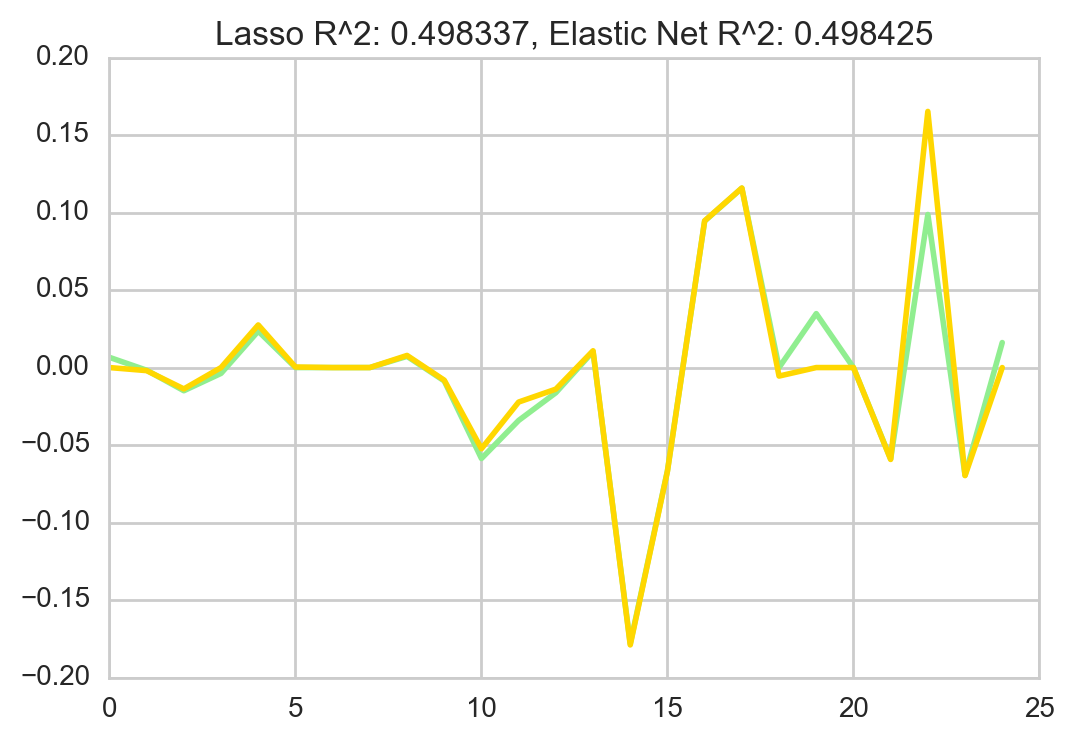

In [30]:
plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lassocv.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
#plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

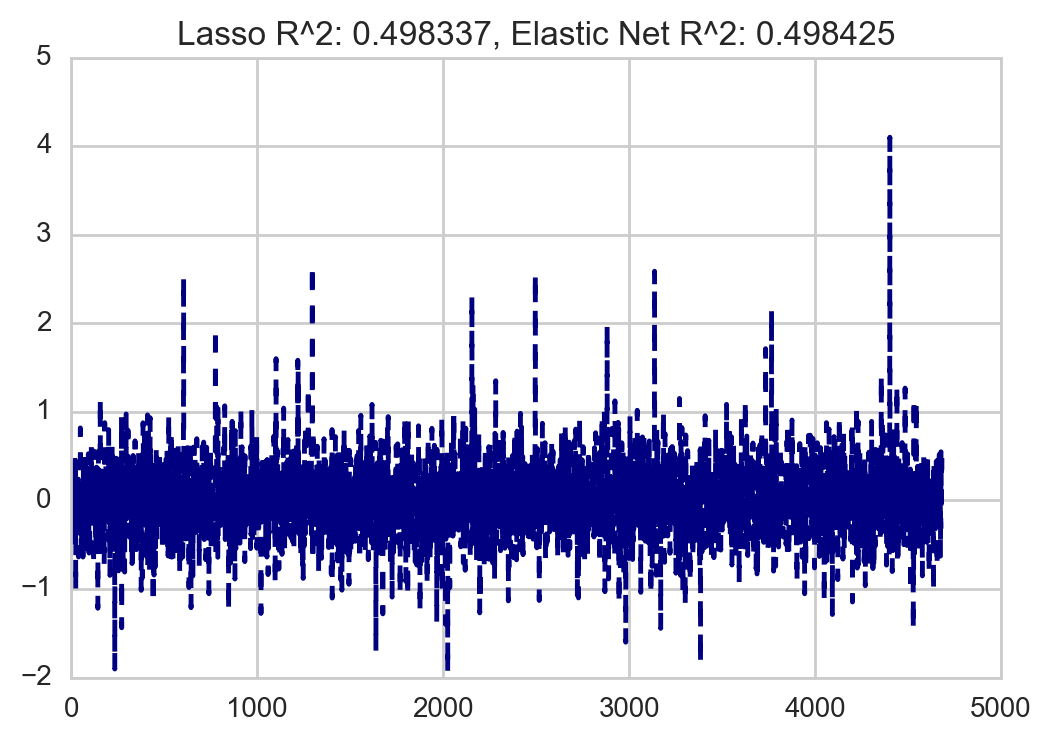

In [31]:
plt.plot(residuals, '--', color='navy', label='original coefficients')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()